In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from adl import DataProcessor, ModelEvaluator, ModelFitter

# Preparation

## Get Data



In [5]:
# Path to Wuerth Data
DATA_PATH = "../01_data/dataset_wuerth.csv"

In [6]:
processor = DataProcessor(DATA_PATH)

combined_condition = lambda df: (df["dunning_level_max"] > 2) & (
    df["dunning_level_current"] > 2
)


data_full = processor.process_data(mode=None, scale="standardize")
data_remove = processor.process_data(
    mode="remove", scale="standardize", conditions=combined_condition
)
data_extract = processor.process_data(
    mode="extract", scale="standardize", target_variable="flag_new_orsyshelf"
)
data_both = processor.process_data(
    mode="both", scale="standardize", conditions=combined_condition
)

Unbiased standardizing applied
Unbiased standardizing applied
Unbiased standardizing applied
Unbiased standardizing applied


# Initial Model Selection

## Full

{'AUC': 0.9549678978997372, 'F1': 0.6588996763754045, 'Log Loss': 0.1476968931376149}


<module 'matplotlib.pyplot' from 'C:\\Users\\sire4\\Documents\\GitHub\\ADL\\venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

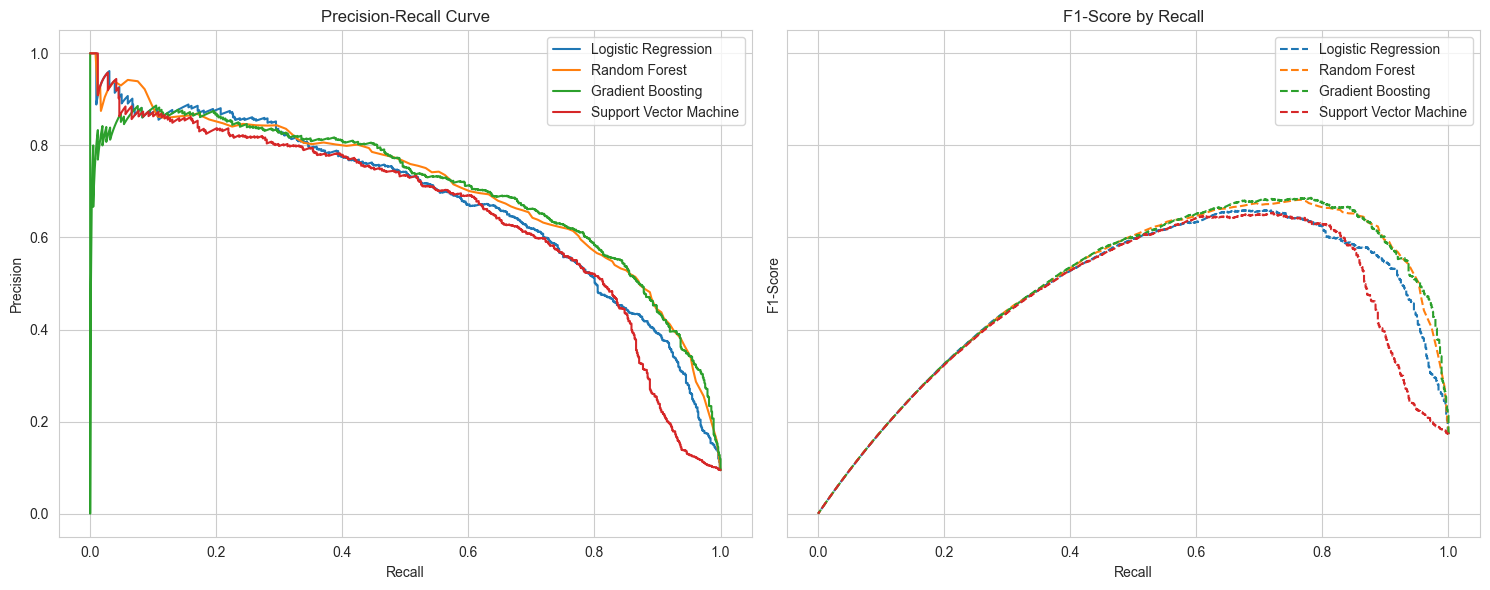

In [7]:
full_eval = ModelEvaluator()
full_eval.fit(data_full, "Full")

full_eval_plot = full_eval.get_plots()
full_eval_score = full_eval.get_scores()
print(full_eval_score["Gradient Boosting"])
full_eval_plot()

## Remove


{'AUC': 0.9502088777440771, 'F1': 0.6437823834196892, 'Log Loss': 0.15302504339855472}


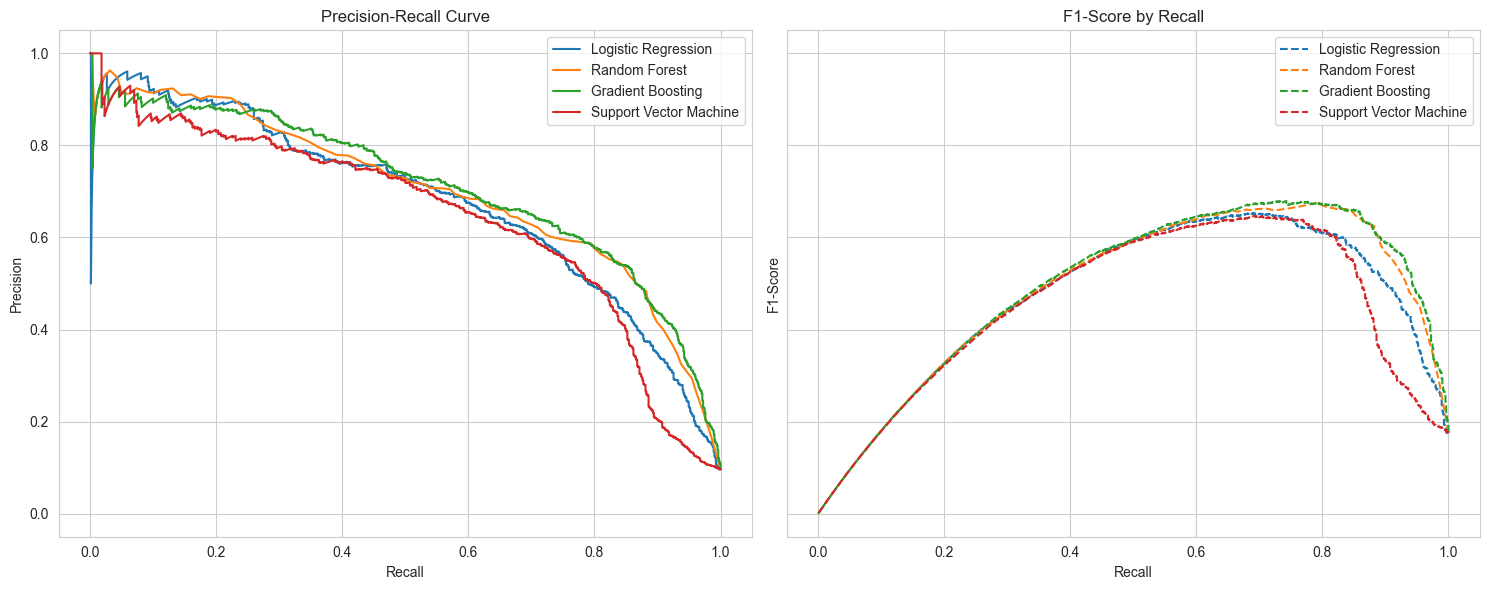

In [8]:
remove_eval = ModelEvaluator()
remove_eval.fit(data_remove, "Remove")

remove_eval_plot = remove_eval.get_plots()
remove_eval_score = remove_eval.get_scores()
print(remove_eval_score["Gradient Boosting"])
remove_eval_plot()

plt.savefig(f"../03_report/graphs/precision.png", dpi=1440)

## Extract

{'AUC': 0.9528365448355587, 'F1': 0.6615285806037251, 'Log Loss': 0.14919931041335216}


<module 'matplotlib.pyplot' from 'C:\\Users\\sire4\\Documents\\GitHub\\ADL\\venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

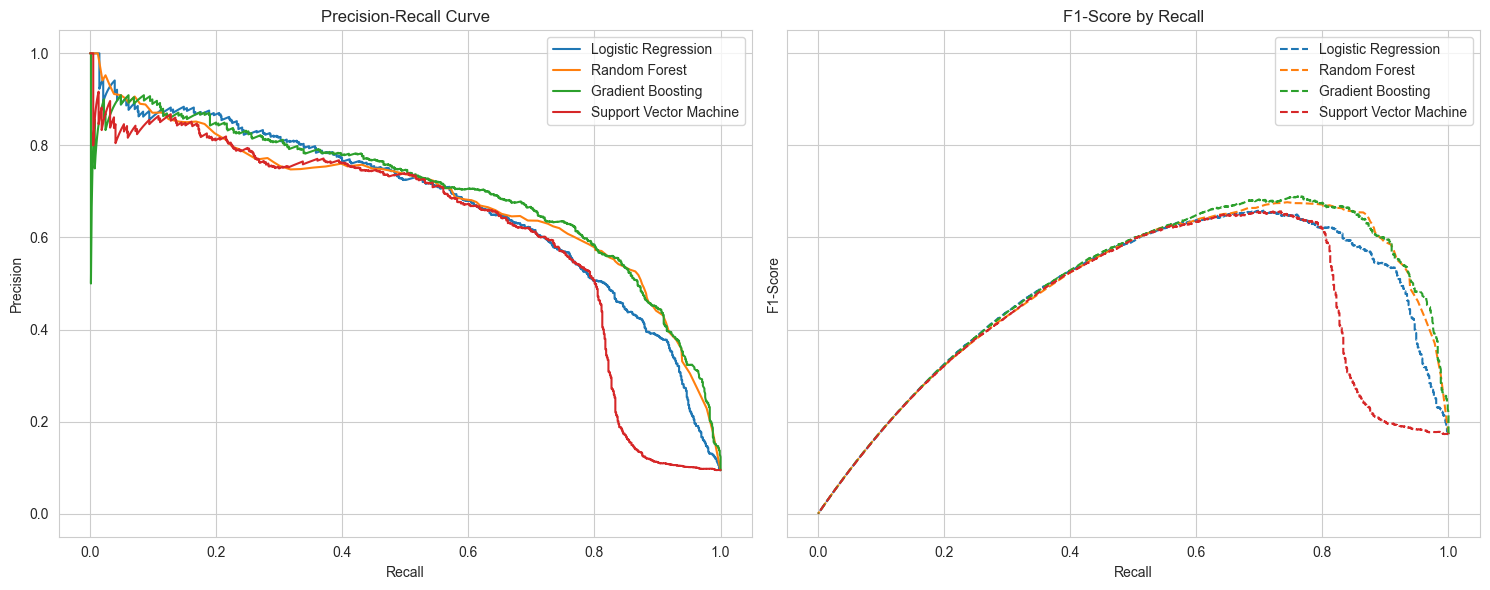

In [9]:
extract_eval = ModelEvaluator()
extract_eval.fit(data_extract, "Extract")

extract_eval_plot = extract_eval.get_plots()
extract_eval_score = extract_eval.get_scores()
print(extract_eval_score["Gradient Boosting"])
extract_eval_plot()

## Both

{'AUC': 0.9481304430783063, 'F1': 0.6373626373626373, 'Log Loss': 0.15507927629188883}


<module 'matplotlib.pyplot' from 'C:\\Users\\sire4\\Documents\\GitHub\\ADL\\venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

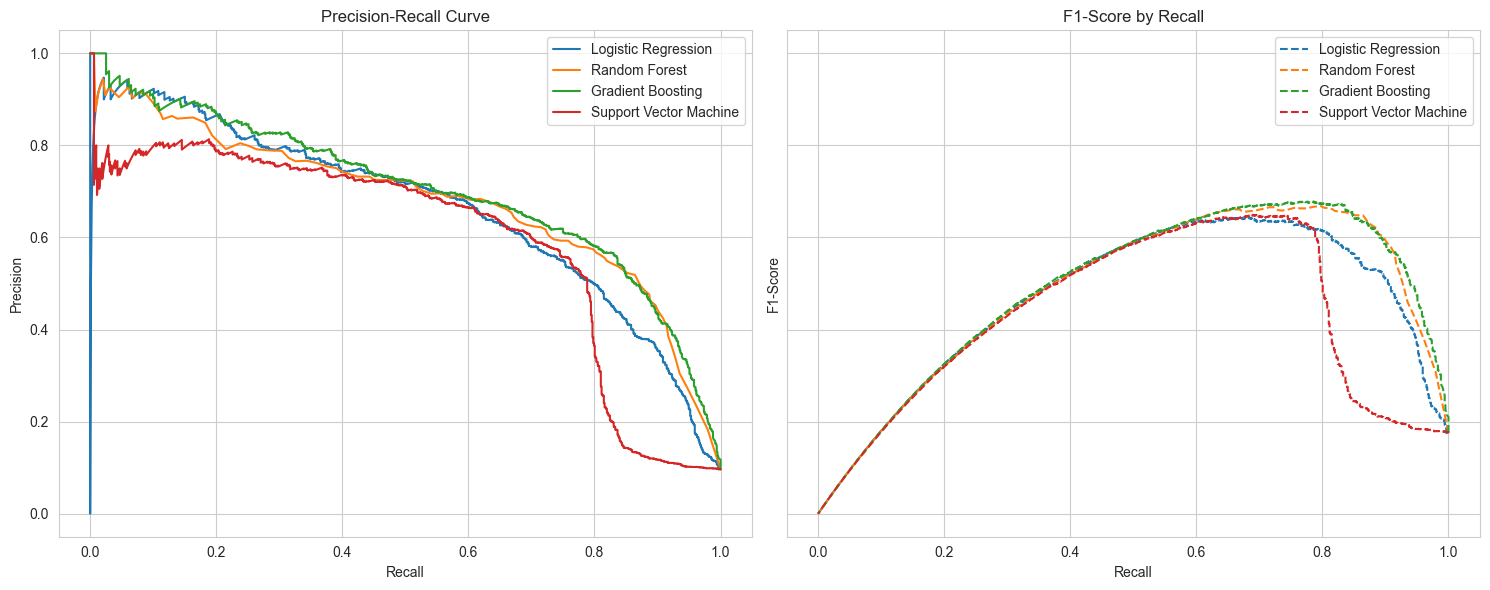

In [10]:
both_eval = ModelEvaluator()
both_eval.fit(data_both, "Both")

both_eval_plot = both_eval.get_plots()
both_eval_score = both_eval.get_scores()
print(both_eval_score["Gradient Boosting"])
both_eval_plot()

By looking at the plots one can see that RF and GB perform best.
In General GB > RF -> focus on GB as fine-tuning all on Hyperparameters is time consuming, especially
considering our 4 datasets

# Hyperparametertuning

 1. Cross validation on hyper parameter tuning is done for gradient boosting for each data set
 2. Comparing the performance of those models with the default ones on the test data (hardly an improvement but the parameters were still used)
 3. Saving those parameters in 01_data/data_model_eval as pickles to be used in `04_orsy_identification.ipynb` (in order to save computational time when evaluating our method)

## Specifying the parameters to tune

In [11]:
gb_params = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": list(range(3, 10, 3)),
    "min_samples_leaf": [1] + np.linspace(0.05, 0.1, 2, endpoint=True).tolist(),
}

## Full data set

{'Gradient Boosting Modified': {'AUC': 0.9553370274718928, 'F1': 0.6606334841628959, 'Log Loss': 0.1470846405205914}, 'Gradient Boosting': {'AUC': 0.9549678978997372, 'F1': 0.6588996763754045, 'Log Loss': 0.1476968931376149}}


<module 'matplotlib.pyplot' from 'C:\\Users\\sire4\\Documents\\GitHub\\ADL\\venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

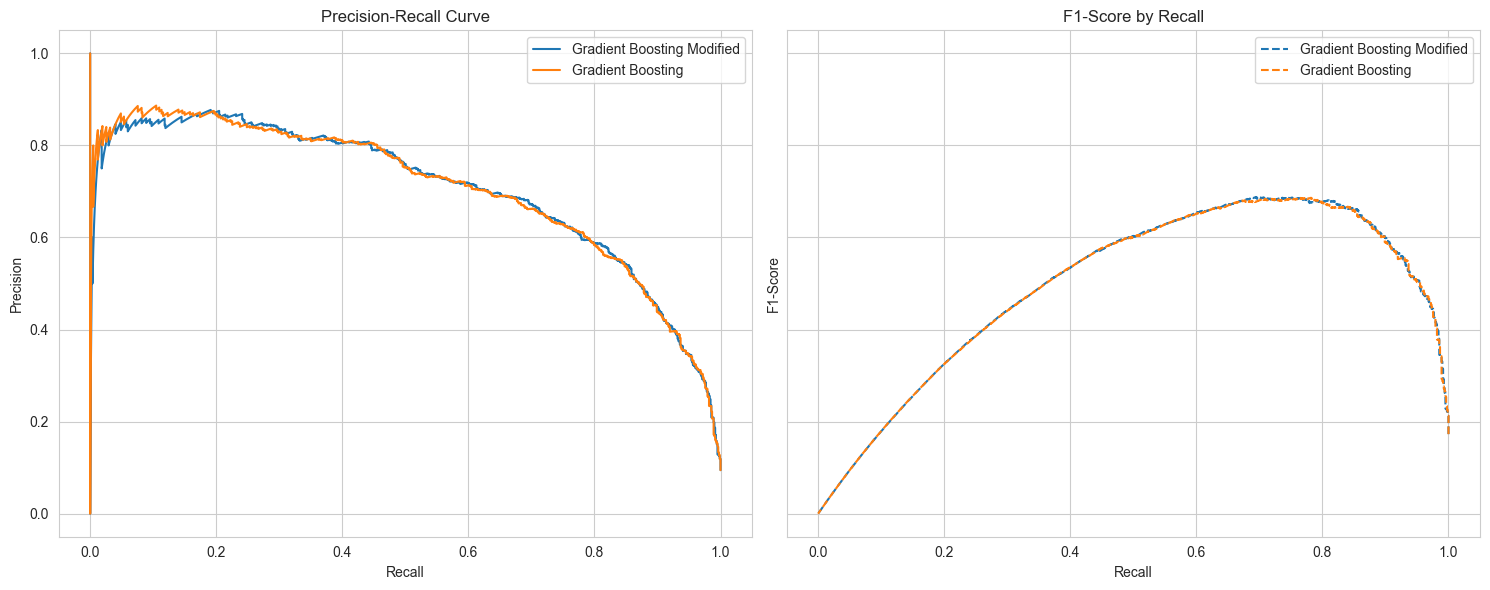

In [12]:
full_tuning = ModelFitter()

full_best_params, full_best_score = full_tuning.grid_fit(
    data_full, gb_params, verbose=0
)

# Comparing with default
# not super efficient but easiest way to implement and compare
full_eval_gb = ModelEvaluator(
    models={
        "Gradient Boosting Modified": GradientBoostingClassifier(
            random_state=0, **full_best_params
        ),
        "Gradient Boosting": GradientBoostingClassifier(random_state=0),
    }
)

full_eval_gb.fit(data_full, "Full")

full_eval_gb_plot = full_eval_gb.get_plots()
full_eval_gb_scores = full_eval_gb.get_scores()
print(full_eval_gb_scores)
full_eval_gb_plot()

In [13]:
with open("../01_data/data_model_eval/full_best_params.pkl", "wb") as file:
    # Use pickle to serialize the dictionary
    pickle.dump(full_best_params, file)

## Remove  data set

{'Gradient Boosting Modified': {'AUC': 0.9489201216680828, 'F1': 0.6485436893203883, 'Log Loss': 0.1522172360164157}, 'Gradient Boosting': {'AUC': 0.9502088777440771, 'F1': 0.6437823834196892, 'Log Loss': 0.15302504339855472}}


<module 'matplotlib.pyplot' from 'C:\\Users\\sire4\\Documents\\GitHub\\ADL\\venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

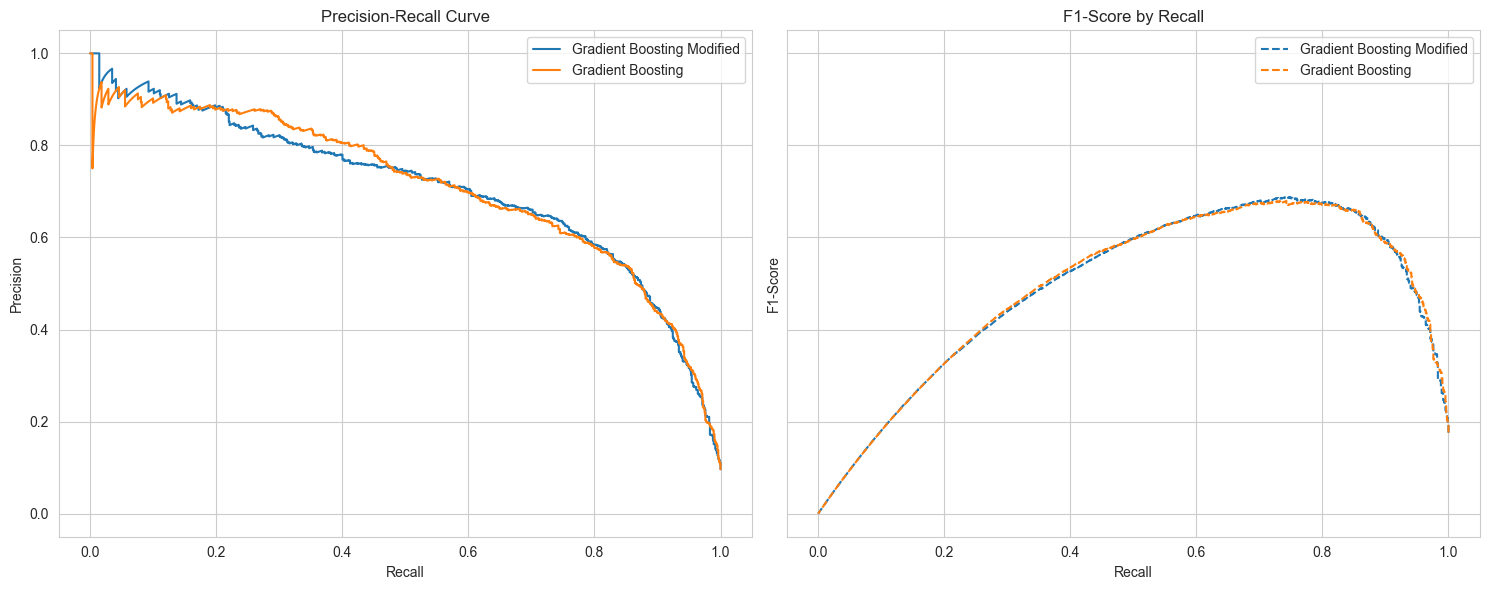

In [14]:
remove_tuning = ModelFitter()

remove_best_params, remove_best_score = remove_tuning.grid_fit(
    data_remove, gb_params, verbose=0
)

# Comparing with default
remove_eval_gb = ModelEvaluator(
    models={
        "Gradient Boosting Modified": GradientBoostingClassifier(
            random_state=0, **remove_best_params
        ),
        "Gradient Boosting": GradientBoostingClassifier(random_state=0),
    }
)

remove_eval_gb.fit(data_remove, "Remove")

remove_eval_gb_plot = remove_eval_gb.get_plots()
remove_eval_gb_scores = remove_eval_gb.get_scores()
print(remove_eval_gb_scores)
remove_eval_gb_plot()

In [15]:
with open("../01_data/data_model_eval/remove_best_params.pkl", "wb") as file:
    # Use pickle to serialize the dictionary
    pickle.dump(remove_best_params, file)

In [16]:
remove_best_params

{'learning_rate': 0.05,
 'max_depth': 6,
 'min_samples_leaf': 0.05,
 'n_estimators': 300}

## Extract

{'Gradient Boosting Modified': {'AUC': 0.9545516289073191, 'F1': 0.6564690885914595, 'Log Loss': 0.14656261226727543}, 'Gradient Boosting': {'AUC': 0.9528365448355587, 'F1': 0.6615285806037251, 'Log Loss': 0.14919931041335216}}


<module 'matplotlib.pyplot' from 'C:\\Users\\sire4\\Documents\\GitHub\\ADL\\venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

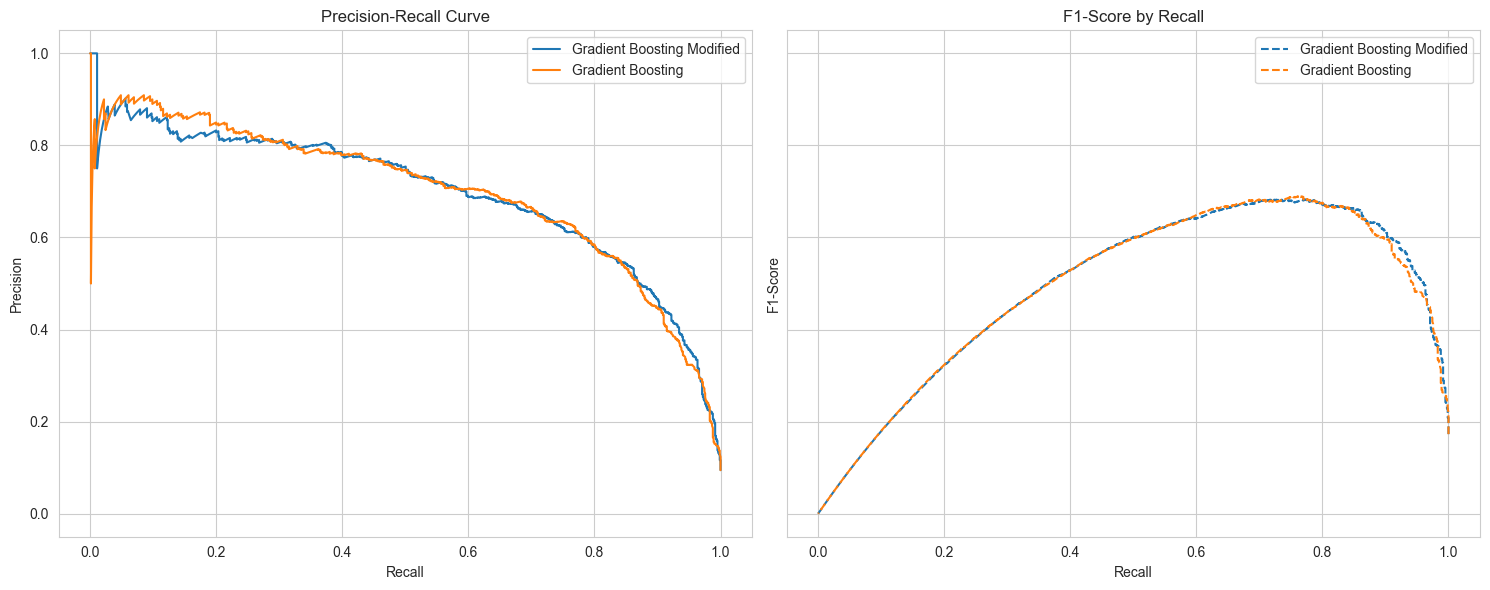

In [17]:
extract_tuning = ModelFitter()

extract_best_params, extract_best_score = extract_tuning.grid_fit(
    data_extract, gb_params, verbose=0
)

# Comparing with default
extract_eval_gb = ModelEvaluator(
    models={
        "Gradient Boosting Modified": GradientBoostingClassifier(
            random_state=0, **extract_best_params
        ),
        "Gradient Boosting": GradientBoostingClassifier(random_state=0),
    }
)

extract_eval_gb.fit(data_extract, "Extract")

extract_eval_gb_plot = extract_eval_gb.get_plots()
extract_eval_gb_scores = extract_eval_gb.get_scores()
print(extract_eval_gb_scores)
extract_eval_gb_plot()

In [18]:
with open("../01_data/data_model_eval/extract_best_params.pkl", "wb") as file:
    # Use pickle to serialize the dictionary
    pickle.dump(extract_best_params, file)

## Both

{'Gradient Boosting Modified': {'AUC': 0.948199677922899, 'F1': 0.6373486297004461, 'Log Loss': 0.15600883217398365}, 'Gradient Boosting': {'AUC': 0.9481304430783063, 'F1': 0.6373626373626373, 'Log Loss': 0.15507927629188883}}


<module 'matplotlib.pyplot' from 'C:\\Users\\sire4\\Documents\\GitHub\\ADL\\venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

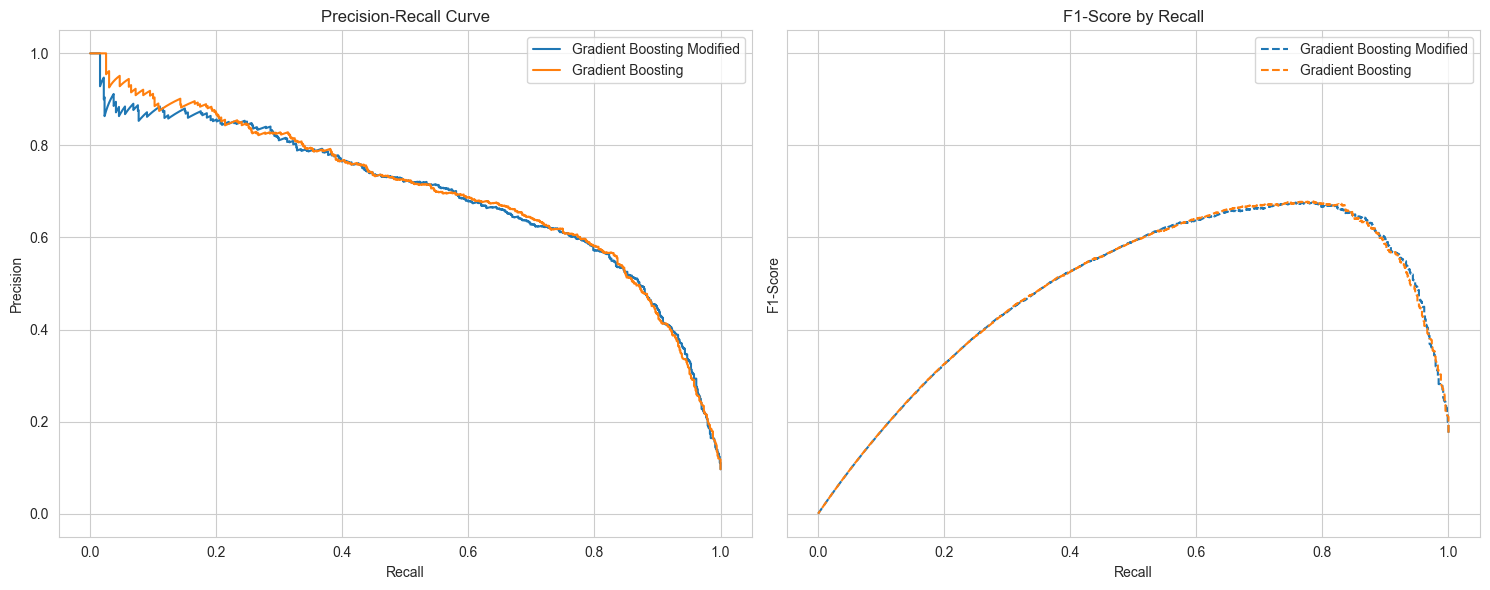

In [19]:
both_tuning = ModelFitter()

both_best_params, both_best_score = both_tuning.grid_fit(
    data_both, gb_params, verbose=0
)


# Comparing with default
both_eval_gb = ModelEvaluator(
    models={
        "Gradient Boosting Modified": GradientBoostingClassifier(
            random_state=0, **both_best_params
        ),
        "Gradient Boosting": GradientBoostingClassifier(random_state=0),
    }
)

both_eval_gb.fit(data_both, "Both")

both_eval_gb_plot = both_eval_gb.get_plots()
both_eval_gb_scores = both_eval_gb.get_scores()
print(both_eval_gb_scores)
both_eval_gb_plot()

In [20]:
with open("../01_data/data_model_eval/both_best_params.pkl", "wb") as file:
    # Use pickle to serialize the dictionary
    pickle.dump(both_best_params, file)